In [37]:
import torch

from IPython.display import HTML
from math import pi
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


sns.set_theme(context="talk", style="whitegrid")

%matplotlib inline

# TODO:
# - split into training and validation
# - what happens with no bias
# - what happens with no nonlinearity (change loss function)

# Create Labeled Dataset

torch.Size([2, 1000])

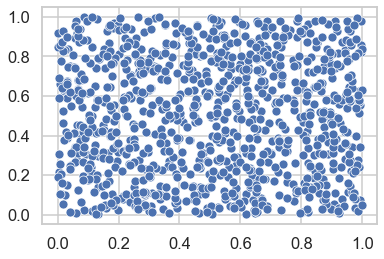

In [38]:
m = 1000

# Input with two features (nx = 2)
x0 = torch.rand(m)
x1 = torch.rand(m)
X = torch.vstack([x0, x1])

sns.scatterplot(x=x0.squeeze(), y=x1.squeeze())

X.shape

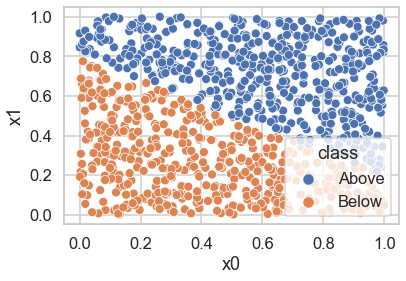

In [97]:
# Create a made-up classification for this data
# Example classification line: y = -0.6x + 0.8
# Converted to standard form: x1 + 0.6x0 - 0.8 = 0

y = torch.zeros(m)
y[x1 + 0.6 * x0 - 0.8 > 0] = 1

classes = ["Above" if target == 1 else "Below" for target in y]
data = pd.DataFrame({"x0": x0, "x1": x1, "class": classes})
sns.scatterplot(data=data, x="x0", y="x1", hue="class");

In [98]:
def bce_loss(yhat, y):
    return -(y * torch.log(yhat) + (1 - y) * torch.log(1 - yhat))


def print_update(epoch, num_epochs, yhat, y):
    losses = bce_loss(yhat, y)
    cost = losses.mean(dim=1).item()
    accuracy = 1 - (yhat - y).abs().mean()

    e = f"{epoch:>4}/{num_epochs}"
    c = f"{cost:0.2f}"
    a = f"{accuracy:0.2f}"
    print(f"{e}: Cost={c}, Accuracy={a}")

    return accuracy

# Batch gradient descent

In [99]:
# Single neuron parameters

n0 = X.shape[0]

w = torch.randn(n0, 1)
b = torch.zeros(1)

ws = [w.clone()]
bs = [b.clone()]

learning_rate = 10
num_epochs = 100
print_step = 5

prev_accuracy = 0

for epoch in range(num_epochs):

    # Forward propagation
    yhat = torch.sigmoid(w.T @ X + b)

    # Compute and print metrics
    if epoch % print_step == 0:
        accuracy = print_update(epoch, num_epochs, yhat, y)

    # Backpropagation
    dZ = yhat - y
    dw = (1 / m) * dZ @ X.T
    db = (1 / m) * dZ.sum()

    # Update parameters
    w -= learning_rate * dw.T
    b -= learning_rate * db

    if accuracy > prev_accuracy + 0.05:
        ws.append(w.clone())
        bs.append(b.clone())
        prev_accuracy = accuracy

print_update(epoch + 1, num_epochs, torch.sigmoid(w.T @ X + b), y);

   0/100: Cost=1.17, Accuracy=0.41
   5/100: Cost=1.42, Accuracy=0.54
  10/100: Cost=0.55, Accuracy=0.67
  15/100: Cost=0.30, Accuracy=0.79
  20/100: Cost=0.20, Accuracy=0.83
  25/100: Cost=0.19, Accuracy=0.85
  30/100: Cost=0.18, Accuracy=0.85
  35/100: Cost=0.17, Accuracy=0.86
  40/100: Cost=0.16, Accuracy=0.87
  45/100: Cost=0.15, Accuracy=0.87
  50/100: Cost=0.15, Accuracy=0.87
  55/100: Cost=0.14, Accuracy=0.88
  60/100: Cost=0.14, Accuracy=0.88
  65/100: Cost=0.14, Accuracy=0.89
  70/100: Cost=0.13, Accuracy=0.89
  75/100: Cost=0.13, Accuracy=0.89
  80/100: Cost=0.13, Accuracy=0.89
  85/100: Cost=0.12, Accuracy=0.90
  90/100: Cost=0.12, Accuracy=0.90
  95/100: Cost=0.12, Accuracy=0.90
 100/100: Cost=0.12, Accuracy=0.90


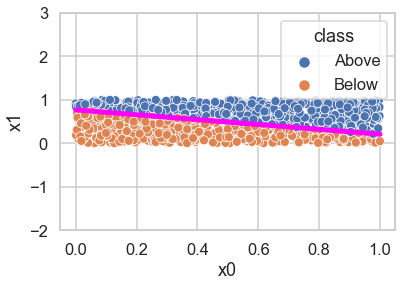

In [46]:
fig, ax = plt.subplots()

sns.scatterplot(data=data, x="x0", y="x1", hue="class", ax=ax)

x_line = torch.tensor([0, 1])
y_line = (-w[0] * x_line - b) / w[1]

(ln,) = ax.plot(x_line, y_line, color="fuchsia", linewidth=5)
ax.set_ylim((-2, 3))

def set_frame_data(i):
    y_line = (-ws[i][0] * x_line - bs[i]) / ws[i][1]
    ln.set_data(x_line, y_line)
    return (ln,)


anim = FuncAnimation(fig, set_frame_data, frames=len(ws))

In [47]:
HTML(anim.to_jshtml())

# Autodifferentiation with Autograd

It is a pain to manually implement the backward pass. We need to know the derivatives of the activation functions and the loss function.

In [53]:
# Single neuron parameters

n0 = X.shape[0]

w = torch.randn(n0, 1, requires_grad=True)
b = torch.zeros(1, requires_grad=True)

ws = [w.clone()]
bs = [b.clone()]

learning_rate = 10
num_epochs = 100
print_step = 5

prev_accuracy = 0

for epoch in range(num_epochs):

    # Forward propagation
    yhat = torch.sigmoid(w.T @ X + b)

    # Compute and print metrics
    if epoch % print_step == 0:
        accuracy = print_update(epoch, num_epochs, yhat, y)

    # Backpropagation
    w.grad = None
    b.grad = None
    losses = mse_loss(yhat, y)
    cost = losses.mean(dim=1)
    cost.backward()

    # Update parameters
    with torch.no_grad():
        w -= learning_rate * w.grad
        b -= learning_rate * b.grad

    if accuracy > prev_accuracy + 0.05:
        ws.append(w.clone())
        bs.append(b.clone())
        prev_accuracy = accuracy

print_update(epoch + 1, num_epochs, torch.sigmoid(w.T @ X + b), y);

   0/100: Cost=0.78, Accuracy=0.49
   5/100: Cost=0.52, Accuracy=0.61
  10/100: Cost=0.46, Accuracy=0.64
  15/100: Cost=0.42, Accuracy=0.67
  20/100: Cost=0.40, Accuracy=0.69
  25/100: Cost=0.38, Accuracy=0.71
  30/100: Cost=0.37, Accuracy=0.72
  35/100: Cost=0.35, Accuracy=0.73
  40/100: Cost=0.35, Accuracy=0.73
  45/100: Cost=0.34, Accuracy=0.74
  50/100: Cost=0.33, Accuracy=0.74
  55/100: Cost=0.33, Accuracy=0.75
  60/100: Cost=0.32, Accuracy=0.75
  65/100: Cost=0.32, Accuracy=0.76
  70/100: Cost=0.32, Accuracy=0.76
  75/100: Cost=0.31, Accuracy=0.76
  80/100: Cost=0.31, Accuracy=0.77
  85/100: Cost=0.31, Accuracy=0.77
  90/100: Cost=0.31, Accuracy=0.77
  95/100: Cost=0.30, Accuracy=0.77
 100/100: Cost=0.30, Accuracy=0.78


In [49]:
def mse_loss(yhat, y):
    return (yhat - y).pow(2)

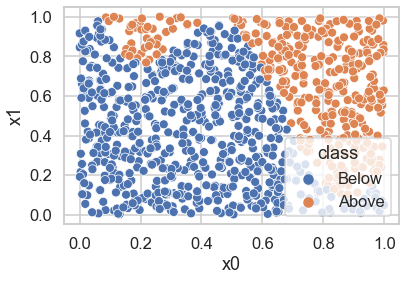

In [50]:
# Create a non-linear made-up classification for this data

y = torch.zeros(m)
noise = 0.25 * torch.sin(x0 * 3 * pi)
y[x1 + x0 - 1.2 + noise > 0] = 1

classes = ["Above" if target == 1 else "Below" for target in y]
data = pd.DataFrame({"x0": x0, "x1": x1, "class": classes})
sns.scatterplot(data=data, x="x0", y="x1", hue="class");

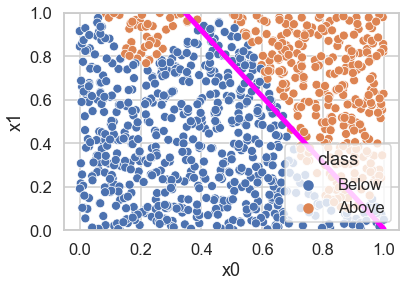

In [54]:
fig, ax = plt.subplots()

sns.scatterplot(data=data, x="x0", y="x1", hue="class", ax=ax)

x_line = torch.tensor([0, 1]).numpy()
y_line = (-w[0].detach().numpy() * x_line - b.detach().numpy()) / w[1].detach().numpy()

(ln,) = ax.plot(x_line, y_line, color="fuchsia", linewidth=5)
ax.set_ylim((0, 1))

def set_frame_data(i):
    y_line = (-ws[i][0].detach().numpy() * x_line - bs[i].detach().numpy()) / ws[i][1].detach().numpy()
    ln.set_data(x_line, y_line)
    return (ln,)


anim = FuncAnimation(fig, set_frame_data, frames=len(ws))

In [55]:
HTML(anim.to_jshtml())

# What about a neural network?

In [101]:
neurons_per_layer = (X.shape[0], 10, 10, 1)

WParams = []
bParams = []
for nl, nlminus1 in zip(neurons_per_layer[1:], neurons_per_layer):
#     print(nl, nlminus1)
    WParams.append(torch.randn(nl, nlminus1, requires_grad=True))
    bParams.append(torch.randn(nl, 1, requires_grad=True))

learning_rate = 2
num_epochs = 100
print_step = 5

prev_accuracy = 0

for epoch in range(num_epochs):

    # Forward propagation
    Alminus1 = X
    for W, b in zip(WParams, bParams):
        Alminus1 = torch.sigmoid(W @ Alminus1 + b)
    yhat = Alminus1

    # Compute and print metrics
    if epoch % print_step == 0:
        accuracy = print_update(epoch, num_epochs, yhat, y)

    # Backpropagation
    for W, b in zip(WParams, bParams):
        W.grad = None
        b.grad = None
    losses = bce_loss(yhat, y)
    cost = losses.mean(dim=1)
    cost.backward()

    # Update parameters
    with torch.no_grad():
        for W, b in zip(WParams, bParams):
            W -= learning_rate * W.grad
            b -= learning_rate * b.grad

   0/100: Cost=1.71, Accuracy=0.51
   5/100: Cost=0.86, Accuracy=0.51
  10/100: Cost=0.68, Accuracy=0.54
  15/100: Cost=0.61, Accuracy=0.56
  20/100: Cost=0.63, Accuracy=0.58
  25/100: Cost=0.63, Accuracy=0.60
  30/100: Cost=0.58, Accuracy=0.62
  35/100: Cost=0.52, Accuracy=0.66
  40/100: Cost=0.50, Accuracy=0.68
  45/100: Cost=0.42, Accuracy=0.72
  50/100: Cost=0.39, Accuracy=0.75
  55/100: Cost=0.33, Accuracy=0.78
  60/100: Cost=0.32, Accuracy=0.80
  65/100: Cost=0.27, Accuracy=0.81
  70/100: Cost=0.27, Accuracy=0.83
  75/100: Cost=0.23, Accuracy=0.84
  80/100: Cost=0.24, Accuracy=0.85
  85/100: Cost=0.20, Accuracy=0.86
  90/100: Cost=0.21, Accuracy=0.87
  95/100: Cost=0.18, Accuracy=0.87


# Neural Network using PyTorch

In [102]:
def print_update(epoch, num_epochs, yhat, y):
    accuracy = 1 - (yhat - y).abs().mean()

    e = f"{epoch:>4}/{num_epochs}"
    a = f"{accuracy:0.2f}"
    print(f"{e}: Accuracy={a}")

    return accuracy

In [112]:
n0 = X.shape[0]
n1 = 10
n2 = 10
n3 = 4
n4 = 1

# Annoyingly for linear: y = xA^T + b
model = torch.nn.Sequential(
    torch.nn.Linear(n0, n1),
    torch.nn.ReLU(),
    torch.nn.Linear(n1, n2),
    torch.nn.ReLU(),
    torch.nn.Linear(n2, n3),
    torch.nn.ReLU(),
    torch.nn.Linear(n3, n4),
    torch.nn.Sigmoid()
)

loss_function = torch.nn.BCELoss()

learning_rate = 0.0001
num_epochs = 100
print_step = 5

prev_accuracy = 0

for epoch in range(num_epochs):

    # Forward propagation
    yhat = model(X.T)

    # Compute and print metrics
    if epoch % print_step == 0:
        accuracy = print_update(epoch, num_epochs, yhat, y)

    # Backpropagation
    model.zero_grad()
    loss = loss_function(yhat, y.unsqueeze(1))
    loss.backward()

    # Update parameters
    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

   0/100: Accuracy=0.50
0.7000211477279663
0.7000206708908081
0.7000202536582947
0.7000200152397156
0.7000195384025574
   5/100: Accuracy=0.50
0.7000194191932678
0.7000189423561096
0.7000187039375305
0.7000182271003723
0.7000178098678589
  10/100: Accuracy=0.50
0.7000175714492798
0.7000172138214111
0.7000169157981873
0.7000165581703186
0.70001620054245
  15/100: Accuracy=0.50
0.7000158429145813
0.7000153660774231
0.7000151872634888
0.7000146508216858
0.7000143527984619
  20/100: Accuracy=0.50
0.7000141143798828
0.7000136971473694
0.7000133395195007
0.7000130414962769
0.7000125646591187
  25/100: Accuracy=0.50
0.7000123262405396
0.7000120282173157
0.7000114917755127
0.7000111937522888
0.7000108361244202
  30/100: Accuracy=0.50
0.7000105977058411
0.7000101804733276
0.7000098824501038
0.7000094652175903
0.7000091075897217
  35/100: Accuracy=0.50
0.7000086903572083
0.7000085711479187
0.700007975101471
0.7000076770782471
0.7000073790550232
  40/100: Accuracy=0.50
0.7000070810317993
0.700006